# _*Reinforcement Learning and Dynamic Optimization*_
## Assignment 2 (2024) - Day Trading in the Stock Market
---
### Student's Info
---
##### ID : 2020030055
##### Full Name : Georgios - Marios Tsikritzakis
---

# Description

In this assignment, your job will be to use the adversarial framework of bandit algorithms we learned (i.e., experts, adversarial bandit algorithms, OCO) in order to optimize your investment in stocks. The setup of the problem is a VERY simplified version of day-to-day trading:

* During the morning of each day, you invest  exactly 1 euro per day on one of K stocks.

* At the end of the day you learn the closing price for this stock, and the percentage (%) of increase or decrease of that stock. You then sell your stock, and you profit exactly that percentage of your 1 euro.

    * e.g. if you invested in stock 3 at day t, and it closed with a gain of 5%, you  get back your 1 euro plus 5 cents.
    * A stock can also lose value during the day. You still must sell, and pick a stock the next morning. E.g. if stock 3 lost 10% then you lose 10 cents (but you will still invest a whole euro the next day).

* The  next day you can invest again 1 euro on any of the K stocks, and so forth, until the end of the horizon.

In the .csv file you will find the day-to-day % changes in 10 real stocks I have compiled from a global stock exchange, for a duration of 2000 days.

\

You need to complete the following tasks:

**Task 1: (Experts Setup)**: Assume that at the end of each day you learn the price change percentage for all K stocks (not just the one you invested in). Implement the Multiplicative Weights algorithm to maximize the amount of profit you have collected at the end of the horizon. You should show two separate plots:

* Cumulative regret of your algorithm, from day 1 to the last day.
* Cumulative profits of your algorithm (i.e., how much you've made in total by day 2, day 3, etc.)

**Task 2: (Experts with Transactions Fees)**: Assume the previous experts setup again (i.e., full feedback) but now each stock n has a fixed transaction cost $c_{i}$ , that differs between stocks.

* E.g. imagine you invested again in stock 3. And let's say that stock 3 has a transaction cost $c_{3} $ = 2% , and shows a price increase of 5%.
* Then, at the end of the day, you will have lost 2 cents for the transaction, and gained 5 from the price increase, for an overall gain of 3 cents.
* Assume that the transactions fees are: 0.5% , 1% , 1.5%...
 for stocks 0 to K, respectively.

Modify your MW algorithm to maximize the accumulated profit (gains minus the transaction costs). Show two plots again, the cumulative regret and the cumulative profit over time, but each one together with the respective plot from the previous scenario with no fees. What do you observe?

**Task 3: (Bandits with Transaction Fees)**: Assume finally that you have a bandit setup, rather than an experts one. I.e. at the end of day t you only learn the % increase/decrease of the stock you invested in that day (but not the other ones). Modify your previous algorithm to be applicable in this bandit setup and maximize the accumulated profit (minus transactions costs).  Plot the cumulative regret and cumulative profits for this scenario and compare with the respective experts plots.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In order to work with the same theoretical algorithms(Multiplicative Weights) we are gonna find the maximum value of loss/gain from the .csv file , to bound the losses/gains in the range [0,1].

Load the stock data in a numpy array,which is gonna be used later on.

In [2]:
import csv
import numpy as np

HORIZON = 2000    # number of days - horizon
stocks_num = 10   # number of stocks-experts

stock_data = np.zeros((HORIZON, stocks_num))


with open("/content/drive/MyDrive/stocks.csv" , "r") as stocks_file :
  csv_reader = csv.reader (stocks_file, delimiter = ',')
  for i,line in enumerate(csv_reader):
    for j in range(stocks_num):
      stock_data[i, j] = float(line[j]) # The array of stock_data contains the % gain/loss of the stock at each day.


# Find the maximum gain value
maximum_gain = np.max(stock_data)

# Find the maximum loss value
maximum_loss = np.min(stock_data)

print(maximum_gain , maximum_loss)



0.2005097706032286 -0.8086677997123807


# Task 1: (Experts Setup)

In [3]:
class MultiplicativeWeights:

  def __init__(self , eta , num_experts):
    self.eta = eta                              # the penalty of the weight - learning rate parameter.
    self.weights = np.ones(num_experts)         # initial weight for each expert.
    self.num_experts = num_experts              # the number of experts.
    self.probabilities = np.zeros(num_experts)  # the probability of each expert to be picked


  def choose_expert(self):
    total_weight = np.sum(self.weights)                                                    # the total weight W
    self.probabilities = self.weights / total_weight                                       # the probability of each expert to be choosed.
    chosen_expert = np.random.choice(np.arange(self.num_experts), p= self.probabilities)   # choose an expert based on the given probabilities
    return chosen_expert


  def update_weights(self , loss_gain_vector):
    for i in range(self.num_experts):
      '''
      First solution:
      '''
      # if the l_i is > 0 i have a gain from this stock , so i have to increase the weight of this expert!
      # if the l_i is < 0 i have a loss so i decrease the weight of this expert.
      # So if l_i > 0 do the exponent <0 so it increases the weight.If l_i <0 do the exponent >0 to decrease the weight.
      # We have to use the normalized losses/gains , to bound them at [0,1] .
      exponent = -loss_gain_vector[i] / maximum_gain if loss_gain_vector[i] > 0 else -loss_gain_vector[i] / maximum_loss
      '''
      Another solution, closer to the original hedge algorithm , is to consider only the negative terms (losses) and decrease the weight
      of these stocks only.Keep the weight of the stocks that have gains the same!
      '''
      #exponent = -loss_gain_vector[i] / maximum_loss if loss_gain_vector[i] < 0 else 0

      multiplication_factor = np.float_power( 1 - self.eta , exponent)
      self.weights[i] = multiplication_factor * self.weights[i]




Simulation code:

Optimal expert: 6
Optimal's expert profit:  4.028565203177035


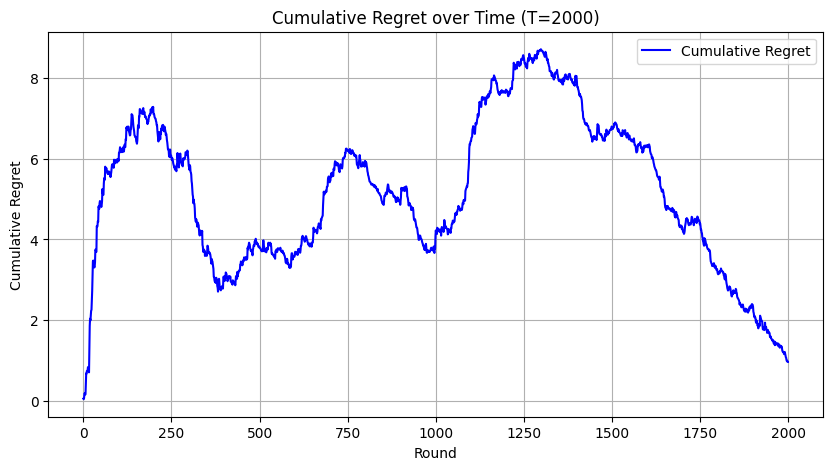

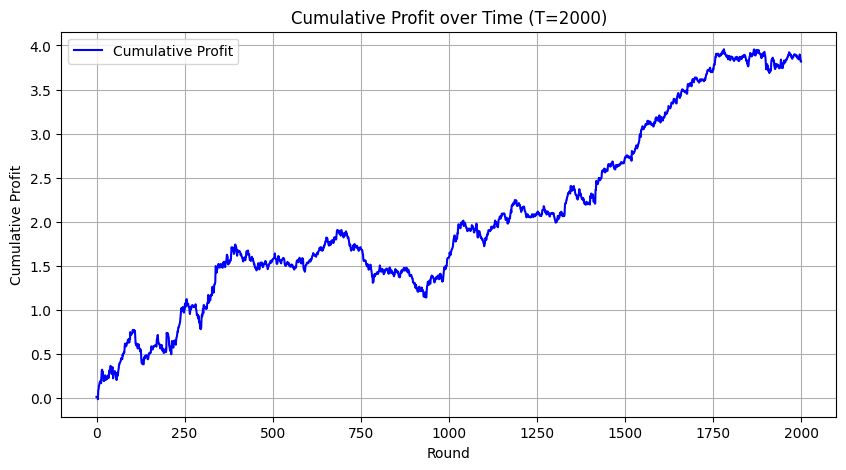

In [6]:
import matplotlib.pyplot as plt

def simulation_task1():
  eta = np.sqrt(np.log(stocks_num) / HORIZON)      # eta = sqrt(lnk / T)
  mwa = MultiplicativeWeights(eta , stocks_num)
  regrets = []
  profits = []

  #The optimal expert is the one that minimizes the loss - maximizes the gain at the end of the Horizon T
  # Calculate the sum of gains for each arm. axis = 0 specifies that the sum should be computed along the columns.
  sum_gains = np.sum(stock_data, axis=0)

  # Find the index of the arm with the maximum sum of gains
  optimal_expert_index = np.argmax(sum_gains)

  print("Optimal expert:", optimal_expert_index)
  print("Optimal's expert profit: ", sum_gains[optimal_expert_index])

  for round in range(HORIZON):

    #choose an expert:
    chosen_expert = mwa.choose_expert()
    percent_val = stock_data[round , chosen_expert]                 # The % loss or gain of the selected stock.

    gain_loss_vector = stock_data[round , :]                         # the loss vector of the current round.Contains all the loss_i
    previous_probs = mwa.probabilities


    # update the weights:
    mwa.update_weights(gain_loss_vector)


    # Compute regret and profit:
    gain_loss_vector_normalized = [gain_loss_vector[i] / maximum_gain if gain_loss_vector[i] > 0 else gain_loss_vector[i] / maximum_loss for i in range(stocks_num)]

    #Compute the Lalg which is the expected loss in current round:
    algorithms_expected_loss = np.sum(previous_probs * gain_loss_vector_normalized)

    # compute the Lopt , which is the instantaneous loss/gain.
    opt_perc_val = stock_data[round , optimal_expert_index]
    optimal_loss_gain = opt_perc_val / maximum_gain if opt_perc_val > 0 else opt_perc_val / maximum_loss

    #Compute the regret = Lalg - Lopt
    '''
    If Lalg - Lopt < 0  , that means the L_opt > L_alg so the optimal expert has more profit , or less loss than the algs choice.So i have regret to add.

    If Lalg - Lopt > 0 , that means that L_alg > L_opt so the algs expert has more profit , or less loss than the optimal expert.So decrease the regret.
    '''
    difference = algorithms_expected_loss - optimal_loss_gain
    regret = (-difference)
    regrets.append(regret)

    #compute the profit , as the %value increase/decrease of stock * 1 dollar invested.
    profits.append(percent_val * 1)

  return np.cumsum(regrets) , np.cumsum(profits)

if __name__ == '__main__':

  cummulative_regret , cummulative_profit = simulation_task1()
  # Plot Cumulative Regret
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_regret, label='Cumulative Regret', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Regret')
  plt.title(f'Cumulative Regret over Time (T={HORIZON})')
  plt.grid(True)
  plt.legend()

  # Plot the Cummulatice profit
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_profit, label='Cumulative Profit', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Profit')
  plt.title(f'Cumulative Profit over Time (T={HORIZON})')
  plt.grid(True)
  plt.legend()

# Task 2: (Experts with Transactions Fees)

In [11]:
'''
Now , because we have transaction fees , we have to recompute the maximum and minimum gain/loss.
'''
transaction_fees = np.array([0.005 * (i + 1) for i in range(stocks_num)]) # transaction_fees = [0.5% , 1.0$ , 1.5% ....] = [0.005$ ...]

# Subtract transaction fees from each row in stock_data
stock_data_minus_fees = stock_data - transaction_fees
print(stock_data_minus_fees)
# Find the maximum gain value after subtracting transaction fees
maximum_gain = np.max(stock_data_minus_fees)

# Find the maximum loss value after subtraction transaction fees
maximum_loss = np.min(stock_data_minus_fees)

print(maximum_gain , maximum_loss)


[[-0.02519499 -0.01548456 -0.03449819 ... -0.02487952 -0.08271904
  -0.02184016]
 [ 0.00850391  0.01077421 -0.02995298 ... -0.03192995 -0.0332716
  -0.0214849 ]
 [ 0.00832398  0.00856806 -0.02517214 ... -0.03714699 -0.07245577
  -0.02029025]
 ...
 [-0.01346492 -0.05185868 -0.01948071 ... -0.0112628  -0.0492898
  -0.08669207]
 [-0.03463389 -0.01280561  0.01394654 ... -0.04999434 -0.05170177
  -0.05322297]
 [-0.005      -0.01       -0.015      ... -0.04       -0.045
  -0.05      ]]
0.1855097706032286 -0.8586677997123807


In [8]:
class MultiplicativeWeightsModification(MultiplicativeWeights):

  def __init__(self , eta , num_experts , transaction_fees ):
    MultiplicativeWeights.__init__(self, eta , num_experts)
    self.transaction_fees = transaction_fees

  # the choose_expert method remains the same!

  #overriden method.
  def update_weights(self , loss_gain_vector):
    '''
      The total loss/gain of a stock is computed by considering the transaction fees!
      Then the algorithm updates the weight as before.
    '''
    loss_gain_vector = loss_gain_vector - self.transaction_fees # The real Loss/Gain values are computed by considering the transaction fees.

    for i in range(self.num_experts):
      exponent = -loss_gain_vector[i] / maximum_gain if loss_gain_vector[i] > 0 else -loss_gain_vector[i] / maximum_loss
      multiplication_factor = np.float_power( 1 - self.eta , exponent)
      self.weights[i] = multiplication_factor * self.weights[i]


Simulation Code:

Optimal expert: 0
Optimal's expert profit:  1.3375228891826854
Optimal expert: 6
Optimal's expert profit:  4.028565203177035


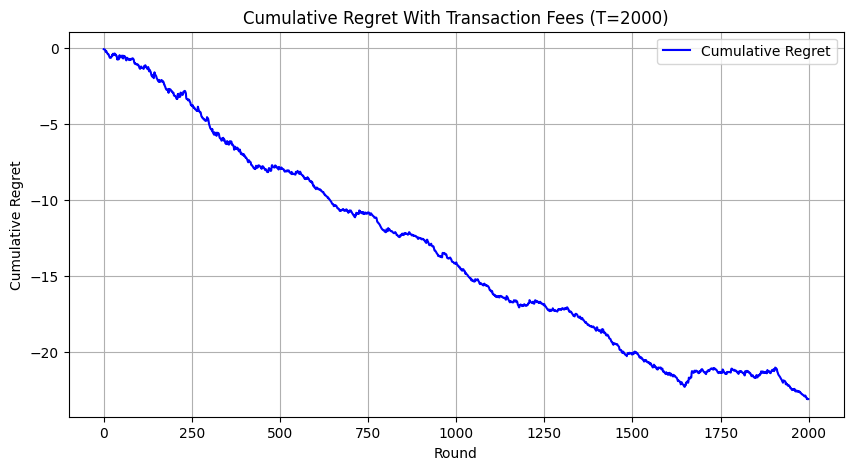

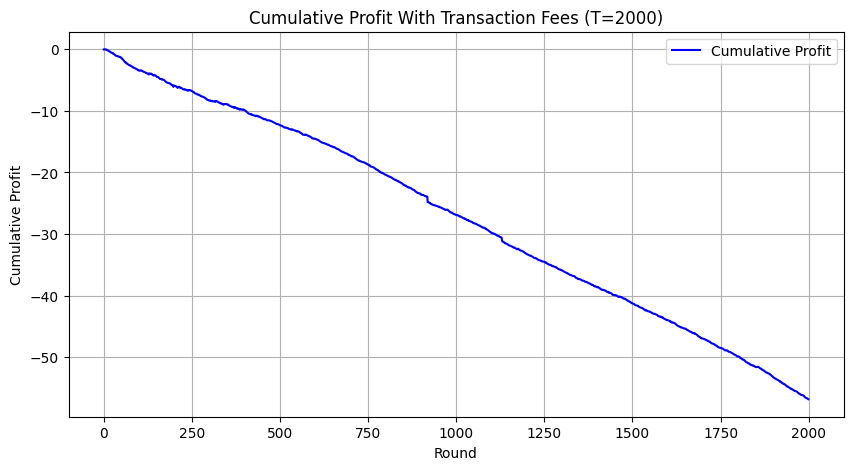

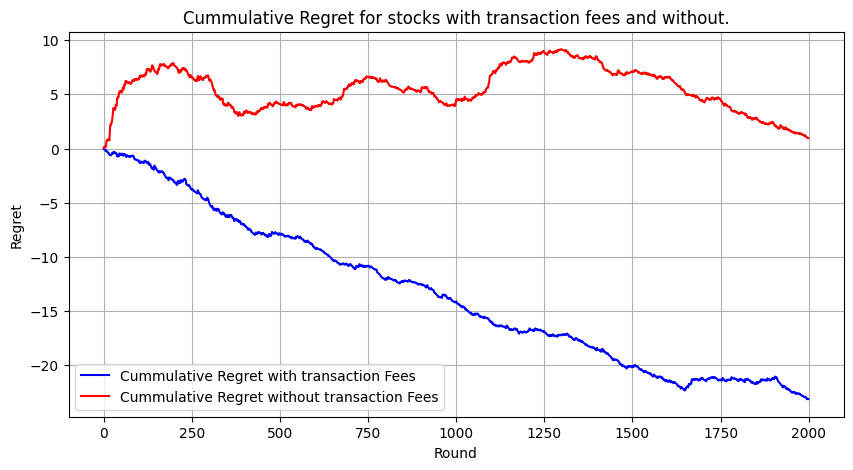

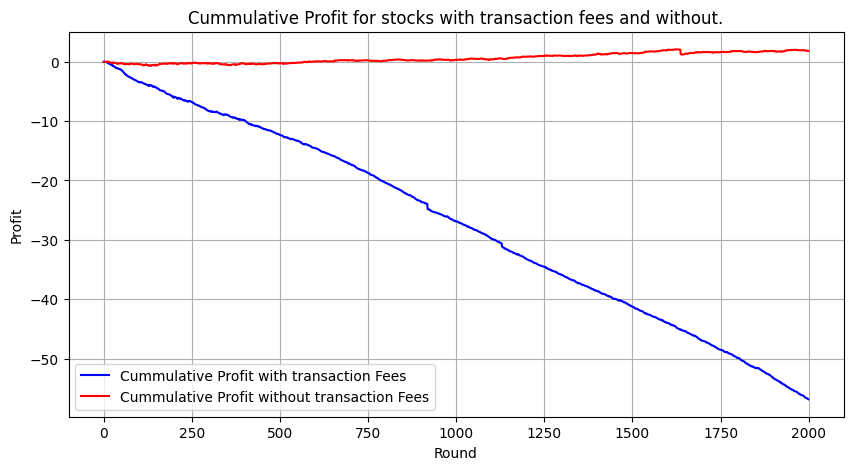

In [10]:
import matplotlib.pyplot as plt

def simulation():

  eta = np.sqrt(np.log(stocks_num) / HORIZON)               # eta = sqrt(lnk / T)
  transaction_fees = [0.005 * (i + 1) for i in range(stocks_num)] # transaction_fees = [0.5% , 1.0$ , 1.5% ....] = [0.005$ ...]
  mwa = MultiplicativeWeightsModification(eta , stocks_num , transaction_fees)
  regrets = []
  profits = []

  #The optimal expert is the one that minimizes the loss - maximizes the gain at the end of the Horizon T, considering also the transaction fees!!
  # Calculate the sum of gains for each arm.axis = 0 specifies that the sum should be computed along the columns.
  sum_gains = np.sum(stock_data, axis=0)

  # Calculate the total transaction fee for each expert (stock).
  total_fees = np.array(mwa.transaction_fees) * len(stock_data)

  # Find the index of the expert with the maximum sum of gains minus total fees
  optimal_expert_index = np.argmax(sum_gains - total_fees)

  print("Optimal expert:", optimal_expert_index)
  print("Optimal's expert profit: ", sum_gains[optimal_expert_index])

  for round in range(HORIZON):

    #choose an expert:
    chosen_expert = mwa.choose_expert()
    percent_val = stock_data[round , chosen_expert]                 # The % loss or gain of the selected stock.

    gain_loss_vector = stock_data[round , :]                         # the loss vector of the current round.Contains all the loss_i
    previous_probs = mwa.probabilities
    # update the weights:
    mwa.update_weights(gain_loss_vector)

    gain_loss_vector_normalized = [gain_loss_vector[i] / maximum_gain if gain_loss_vector[i] > 0 else gain_loss_vector[i] / maximum_loss for i in range(stocks_num)]

    #Compute the Lalg which is the expected loss in current round:
    algorithms_expected_loss = np.sum(previous_probs * gain_loss_vector_normalized)

    # compute the Lopt , which is the instantaneous loss/gain.
    opt_perc_val = stock_data[round , optimal_expert_index]
    optimal_loss_gain = opt_perc_val / maximum_gain if opt_perc_val > 0 else opt_perc_val / maximum_loss

    #Compute the regret = Lalg - Lopt
    '''
    If Lalg - Lopt < 0  , that means the L_opt > L_alg so the optimal expert has more profit , or less loss than the algs choice.So i have regret to add.

    If Lalg - Lopt > 0 , that means that L_alg > L_opt so the algs expert has more profit , or less loss than the optimal expert.So decrease the regret.
    '''
    difference = algorithms_expected_loss - optimal_loss_gain
    regret = (-difference)
    regrets.append(regret)

    #compute the profit , as the %value increase/decrease of stock * 1 dollar invested.
    profits.append( (percent_val - transaction_fees[chosen_expert] )* 1)

  return np.cumsum(regrets) , np.cumsum(profits)

if __name__ == '__main__':

  cummulative_regret , cummulative_profit = simulation()
  # Plot Cumulative Regret
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_regret, label='Cumulative Regret', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Regret')
  plt.title(f'Cumulative Regret With Transaction Fees (T={HORIZON})')
  plt.grid(True)
  plt.legend()

  # Plot the Cummulatice profit
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_profit, label='Cumulative Profit', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Profit')
  plt.title(f'Cumulative Profit With Transaction Fees (T={HORIZON})')
  plt.grid(True)
  plt.legend()

  # Plot Regret and Profit for both implementations with transaction fees and not at the same plot.

  cummulative_regret_task1 , cummulative_profit_task1 = simulation_task1()

  plt.figure(figsize=(10, 5))
  # Plotting the graphs:
  plt.plot(cummulative_regret , label='Cummulative Regret with transaction Fees', color='blue', linestyle='-')
  plt.plot(cummulative_regret_task1, label='Cummulative Regret without transaction Fees', color='red', linestyle='-')
  # Adding a legend
  plt.legend()
  # Adding grid
  plt.grid(True)
  # Adding labels and title
  plt.xlabel('Round')
  plt.ylabel('Regret')
  plt.title('Cummulative Regret for stocks with transaction fees and without.')

  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_profit , label='Cummulative Profit with transaction Fees', color='blue', linestyle='-')
  plt.plot(cummulative_profit_task1, label='Cummulative Profit without transaction Fees', color='red', linestyle='-')
  # Adding a legend
  plt.legend()
  # Adding grid
  plt.grid(True)
  # Adding labels and title
  plt.xlabel('Round')
  plt.ylabel('Profit')
  plt.title('Cummulative Profit for stocks with transaction fees and without.')

# Task 3: (Bandits with Transaction Fees)

In [14]:

class MultiplicativeWeightsForBandits(MultiplicativeWeightsModification):

  def __init__(self , eta , num_experts , transaction_fees ,  epsilon):
    MultiplicativeWeightsModification.__init__(self , eta , num_experts , transaction_fees)
    self.epsilon = epsilon # The exploration probability


  def choose_expert(self):
    total_weight = np.sum(self.weights)                                                             # the total weight W
    p = self.weights / total_weight                                                                 # the p in bibliography
    self.probabilities = (1 - self.epsilon) * p + (self.epsilon / self.num_experts)                 # the array from which we will choose an arm,q in bibliography
    chosen_expert = np.random.choice(np.arange(self.num_experts), p=self.probabilities)             # choose an expert based on the given probabilities
    return chosen_expert


  def update_weights(self , chosen_arm_loss , chosen_expert):
    '''
    Remeber that if we have a loss(value<0) we want the exponent to be positive,and thats why we have the minus there.
    If we have gain(value >0) we want negative exponent to increase the total weight!
    '''
    chosen_arm_loss = -(chosen_arm_loss - self.transaction_fees[chosen_expert])                                   # consider also the loss due to transaction fee.
    chosen_arm_loss = chosen_arm_loss / maximum_gain if chosen_arm_loss >0 else chosen_arm_loss / maximum_loss    # loss normalized.
    loss_hat        = chosen_arm_loss / self.probabilities[chosen_expert]                                         # the unbiased estimate of loss .
    rho             = self.num_experts / self.epsilon                                                             # rho = n/e = the max value a loss can get.
    loss_normalized = loss_hat / rho                                                                              # the unbiased estimate of loss , normalized.That's what we feed the algorithm
    # Change only the weight of the arm picked, and keep all the other weights unchanged.
    self.weights[chosen_expert] = np.float_power( (1 - self.eta) , loss_normalized ) * self.weights[chosen_expert]



Simulation Code:

Optimal arm: 0
Optimal's expert profit:  1.3375228891826854


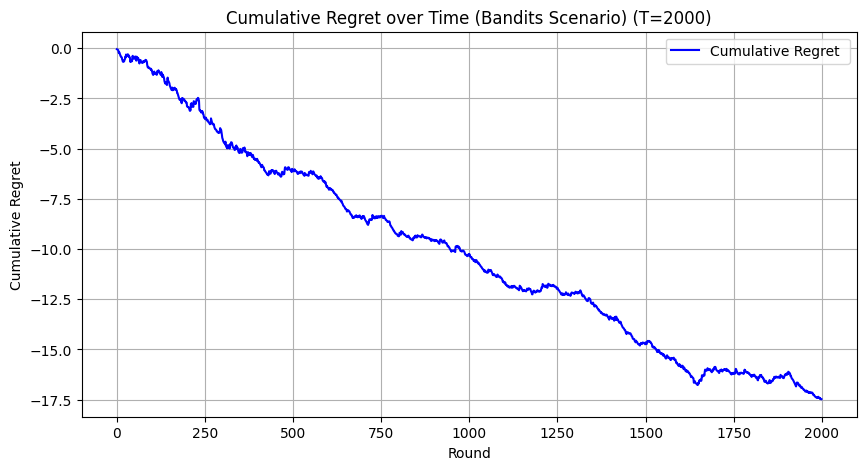

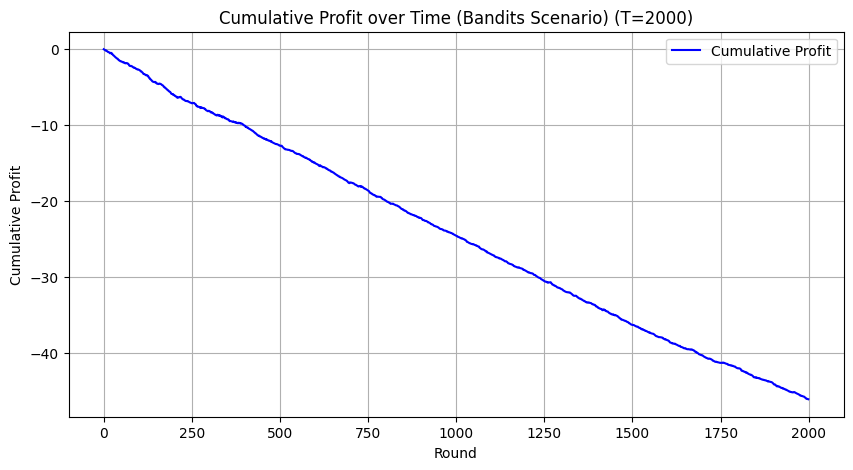

In [15]:
import matplotlib.pyplot as plt

def simulation():
  epsilon = eta = np.cbrt( (stocks_num * np.log(stocks_num))/HORIZON )                # eta = e = cube root of ( (k* lnk) / T)
  transaction_fees = [0.005 * (i + 1) for i in range(stocks_num)]                     # transaction_fees = [0.5% , 1.0$ , 1.5% ....]
  mwa = MultiplicativeWeightsForBandits(eta , stocks_num , transaction_fees , epsilon)
  regrets = []
  profits = []
  #The optimal expert is the one that minimizes the loss - maximizes the gain at the end of the Horizon T, considering also the transaction fees!!
  # Calculate the sum of gains for each arm.axis = 0 specifies that the sum should be computed along the columns.
  sum_gains = np.sum(stock_data, axis=0)

  # Calculate the total transaction fee for each expert (stock)
  total_fees = np.array(mwa.transaction_fees) * len(stock_data)

  # Find the index of the arm with the maximum sum of gains minus total fees
  optimal_arm_index = np.argmax(sum_gains - total_fees)

  print("Optimal arm:", optimal_arm_index)
  print("Optimal's expert profit: ", sum_gains[optimal_arm_index])

  for round in range(HORIZON):

    #choose an arm:
    chosen_arm = mwa.choose_expert()
    percent_val = stock_data[round , chosen_arm]                 # The % loss or gain of the selected stock.

    #print(type(chosen_arm))
    # update the weights:
    mwa.update_weights(percent_val , chosen_arm)

    #Compute the Lalg which is the expected loss in current round:
    sum_of_lalgs = 0.0

    for i in range(100):
      algs_loss_perc = percent_val = stock_data[round , mwa.choose_expert()]
      loss_normalized = algs_loss_perc / maximum_gain if algs_loss_perc >0 else algs_loss_perc / maximum_loss
      sum_of_lalgs += loss_normalized

    algorithms_expected_loss = sum_of_lalgs / 100


    # compute the Lopt , which is the instantaneous loss/gain.
    opt_perc_val = stock_data[round , optimal_arm_index]
    optimal_loss_gain = opt_perc_val / maximum_gain if opt_perc_val > 0 else opt_perc_val / maximum_loss

    #Compute the regret = Lalg - Lopt
    '''
    If Lalg - Lopt < 0  , that means the L_opt > L_alg so the optimal expert has more profit , or less loss than the algs choice.So i have regret to add.

    If Lalg - Lopt > 0 , that means that L_alg > L_opt so the algs expert has more profit , or less loss than the optimal expert.So decrease the regret.
    '''
    difference = algorithms_expected_loss - optimal_loss_gain
    regret = (-difference)
    regrets.append(regret)

    #compute the profit , as the %value increase/decrease of stock * 1 dollar invested.
    profits.append( (percent_val - transaction_fees[chosen_arm] ) * 1)

  return np.cumsum(regrets) , np.cumsum(profits)

if __name__ == '__main__':

  cummulative_regret , cummulative_profit = simulation()
  # Plot Cumulative Regret
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_regret, label='Cumulative Regret ', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Regret')
  plt.title(f'Cumulative Regret over Time (Bandits Scenario) (T={HORIZON})')
  plt.grid(True)
  plt.legend()

  # Plot the Cummulatice profit
  plt.figure(figsize=(10, 5))
  plt.plot(cummulative_profit, label='Cumulative Profit', color='blue')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Profit')
  plt.title(f'Cumulative Profit over Time (Bandits Scenario) (T={HORIZON})')
  plt.grid(True)
  plt.legend()